

# **Predicción con iKNN**


# Descargando la información


In [2]:
import pandas as pd

train_file = pd.read_csv('../data/training_set.csv', sep=',', header=0)
train_file.head()

,userID,itemID,styleID,rating
0,401,32780,12224,3.0
1,7548,21688,9020,3.5
2,7663,1521,568,4.0
3,1357,3824,1417,3.5
4,1361,727,263,4.5


In [3]:
validation_file = pd.read_csv('../data/validation_set.csv', sep=',', header=0)
validation_file.head()

,userID,itemID,styleID,rating
0,1040,4920,1315,4.0
1,1306,7348,1199,4.0
2,932,4073,1199,4.0
3,6735,16074,1199,4.5
4,197,39299,3268,4.0


## Preparando entorno

In [4]:
!pip install pyreclab

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [26]:
import pyreclab
import numpy as np
import json
import os
import heapq
import psutil
import math
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import pandas as pd
import time

## ItemKNN


In [5]:
myItemKnn = pyreclab.ItemKnn(dataset='../data/training_set.csv',
                             dlmchar=b',',
                             header=False,
                             usercol=0,
                             itemcol=1,
                             ratingcol=3)

## Análisis de sensibilidad - K vecinos

Utilizando **Pearson**

In [6]:
k_values = [10, 30, 50, 70, 100, 130] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myItemKnn.train(k,'pearson')
  predlist, mae, rmse = myItemKnn.test( input_file = '../data/validation_set.csv',dlmchar = b',', header = False, usercol = 0, itemcol = 1, ratingcol = 3, output_file = 'predictions.csv' )
  rmse_values.append(rmse)
  mae_values.append(mae)

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Wa

rning: item id '76997' was not included in training set

raining set

t included in training set


ot included in training set


RMSE: [0.6469102510732198, 0.6439864507162134, 0.643946262612739, 0.6439429321095623, 0.6439429730267305, 0.6439429730267305]
MAE: [0.48376846984413185, 0.4809134764405662, 0.4808674767169936, 0.4808639917675418, 0.4808641741604454, 0.4808641741604454]


Utilizando **Coseno**

In [7]:
k_values = [10, 30, 50, 70, 100, 130] # definir distintos valores de vecinos (k)
cosine_mae_values = [] # para almacenar resultados de MAE
cosine_rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myItemKnn.train(k,'cosine')
  predlist, mae, rmse = myItemKnn.test( input_file = '../data/validation_set.csv',dlmchar = b',', header = False, usercol = 0, itemcol = 1, ratingcol = 3, output_file = 'predictions.csv' )
  cosine_rmse_values.append(rmse)
  cosine_mae_values.append(mae)

print('RMSE:', cosine_rmse_values)
print('MAE:', cosine_mae_values)

 included in training set

id '29292' was not included in training set

 id '70647' was not included in training set

 not included in training set

d '64233' was not included in training set


RMSE: [0.6182878542249972, 0.6142702256604623, 0.614154470863652, 0.6141385150500701, 0.6141420311322998, 0.6141378703476901]
MAE: [0.46229314567190816, 0.45950623675536245, 0.4594833024538282, 0.45943771357170016, 0.45943943530741677, 0.4594386002225391]


Para pearson:

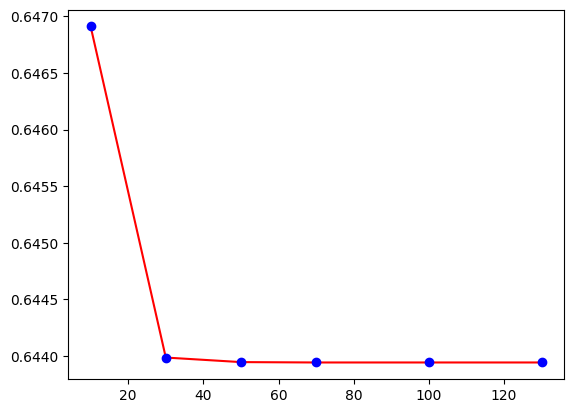

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.show()

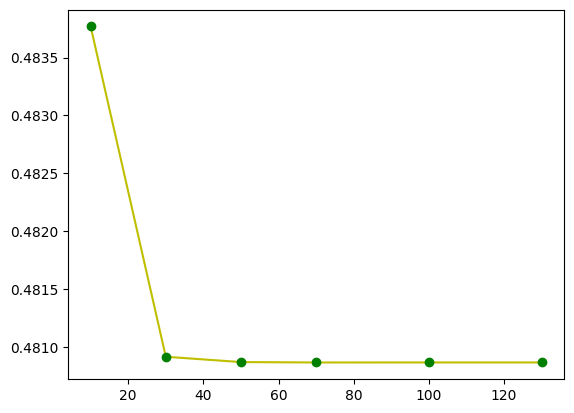

In [9]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.show()

Para Coseno:

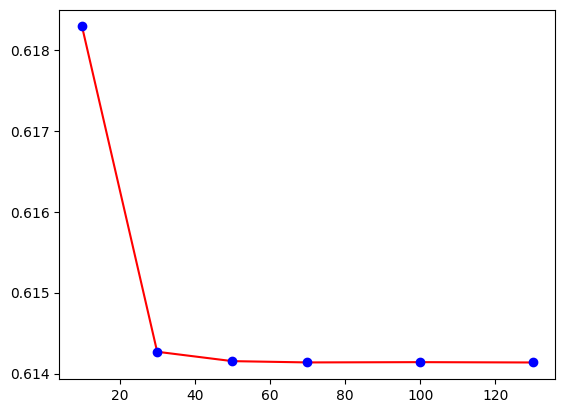

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, cosine_rmse_values, 'r-')
plt.plot(k_values, cosine_rmse_values, 'bo')
plt.show()

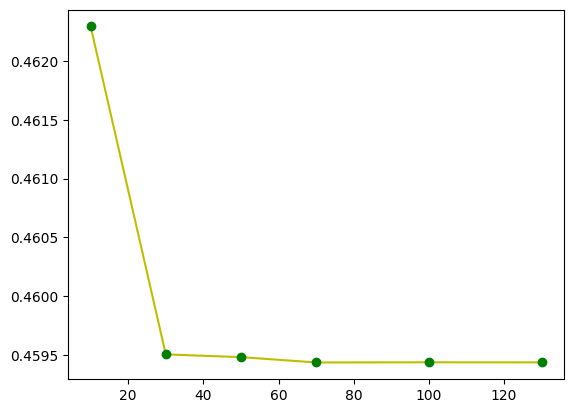

In [11]:
plt.plot(k_values, cosine_mae_values, 'y-')
plt.plot(k_values, cosine_mae_values, 'go')
plt.show()

## Entrenando modelo

In [6]:
myItemKnn.train(100,'cosine')

## Métricas de predicción

In [7]:
predlist, mae, rmse = myItemKnn.test(input_file='../data/validation_set.csv',
                               dlmchar=b',',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=3)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.45943943530741677
RMSE: 0.6141420311322998


## Métricas de recomendación

In [10]:
top_n = 10

recommendList, maprec, ndcg = myItemKnn.testrec(input_file='../data/validation_set.csv',
                                          dlmchar=b',',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=3,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.0012899443039758505
NDCG@10: 0.0011315624764908724


In [14]:
user_id = 5401
top_n = 10 
ranking = [int(r) for r in myItemKnn.recommend(str(user_id), top_n, includeRated=False)]

print('IKNN: Recommendation for user {}: {}'.format(user_id, ranking))

IKNN: Recommendation for user 5401: [65796, 72618, 72009, 72007, 20480, 66856, 75449, 65636, 63020, 65568]


In [15]:
user_ratings = validation_file[validation_file['userID'] == user_id]
average_rating = user_ratings['rating'].mean()
relevants_items = user_ratings['itemID'].tolist()

print('Relevants items for user {}: {}'.format(user_id, relevants_items))

Relevants items for user 5401: [17538, 21822, 20478, 5441, 19960]


In [16]:
def recall_at_k(relevant_items, recommended_items, k):
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items[:k])
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items)
    return recall

In [19]:
recall = myItemKnn.recall(str(user_id), ranking, relevance_threshold=2)
print('iKNN recall: {}'.format(recall))

iKNN recall: 0.0


## Rating

In [14]:
rating_test = pd.read_csv('../templates/rating_template_fill.csv', sep=';', header=0)
rating_test.head()

,itemID,styleID,Rating,userID
0,39289,14756,NaN,715
1,3939,1417,NaN,4944
2,47695,14879,NaN,4890
3,7348,1199,NaN,5324
4,37403,1199,NaN,5544


In [15]:
# Función para obtener el promedio de ratings de un usuario en caso de que el item no esté en training
def user_average_rating(user_id, train_ratings):
    user_ratings = train_ratings[train_ratings['userID'] == user_id]['rating']
    if len(user_ratings) > 0:
        return user_ratings.mean()
    else:
        return train_ratings['rating'].mean()

# Lista de ítems en training
training_items = train_file['itemID'].unique()

In [16]:
for index, row in rating_test.iterrows(): 
    user_id = str(int(row.iloc[3]))
    item_id = str(int(row.iloc[0]))

    if int(item_id) not in training_items:
      rating = user_average_rating(user_id, train_file)
    else:
      rating = myItemKnn.predict(user_id, item_id)
    rating_test.at[index, 'Rating'] = rating


In [17]:
rating_test.head()

,itemID,styleID,Rating,userID
0,39289,14756,4.080112,715
1,3939,1417,3.764879,4944
2,47695,14879,3.696038,4890
3,7348,1199,4.501630,5324
4,37403,1199,3.920709,5544


In [18]:
ruta = os.path.join('../predictions', 'rating_iknn.csv')
rating_test.to_csv(ruta, index=False)

## Ranking

In [27]:
import json

ranking_test = json.load(open('../templates/ranking_template_fill.json'))

In [28]:
# Entrenar con archivo de validación
myitemvalidation = pyreclab.ItemKnn(dataset='../data/validation_set.csv',
                             dlmchar=b',',
                             header=False,
                             usercol=0,
                             itemcol=1,
                             ratingcol=3)

In [29]:
#Entrenar
start_time = time.time()
mem_info_before = psutil.virtual_memory().used
cpu_usage_before = psutil.cpu_percent(interval=None)

myitemvalidation.train(100,'cosine')

end_time = time.time()
mem_info_after = psutil.virtual_memory().used
memory_used = (mem_info_after - mem_info_before) / (1024 ** 2)
cpu_usage_after = psutil.cpu_percent(interval=None)

print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")
print(f"Memoria utilizada: {memory_used} MB")
print(f"Uso de CPU: {cpu_usage_after - cpu_usage_before}%")


Tiempo de entrenamiento: 0.659104585647583 segundos
Memoria utilizada: 12.05078125 MB
Uso de CPU: 4.7%


In [25]:
#Función para obtener las recomendaciones por cada usuario
def generate_recommendations(userID, top_n=10):
  recommendation = myitemvalidation.recommend(userID, top_n)
  return recommendation

In [8]:
for user in ranking_test.keys():
    ranking = myitemvalidation.recommend(user)
    ranking = [int(r) for r in ranking]
    ranking_test[user] = ranking

In [9]:
with open(os.path.join("..", "predictions", "iKNN_ranking.json"), "w") as file:
    json.dump(ranking_test, file, indent=4)

## Evaluación del ranking

Diversidad

In [13]:
items_styles = pd.read_csv('../data/items_styles.csv', sep=',', header=0)
item_categories = items_styles.set_index('itemID')['styleID'].to_dict()
categorias_recomendadas = [item_categories[item] for item in ranking]

# Calcular la proporción de categorías únicas
categorias_unicas = len(set(categorias_recomendadas))
diversidad = categorias_unicas / len(ranking)
print('Diversidad: {}'.format(diversidad))

Diversidad: 0.5


Novedad

In [15]:
item_counts = train_file['itemID'].value_counts()
total_interacciones = len(train_file)
items_popularity = item_counts / total_interacciones
items_popularity = items_popularity.to_dict()

In [22]:
def calcular_novedad(recomendaciones_usuarios, items_popularity):
    num_usuarios = len(recomendaciones_usuarios)
    novedad_total = 0

    for usuario, recomendaciones in recomendaciones_usuarios.items():
        novedad_usuario = 0
        
        for item in recomendaciones:
            if item in items_popularity:
                novedad_usuario += np.log(1 / items_popularity[item])
            else:
                print(f"El ítem {item} no está en items_popularity, se ignora.")

        novedad_total += novedad_usuario / len(recomendaciones)

    novedad_promedio = novedad_total / num_usuarios
    return novedad_promedio

In [23]:
novedad = calcular_novedad(ranking_test, items_popularity)
print('Novedad: {}'.format(novedad))

El ítem 44081 no está en items_popularity, se ignora.
El ítem 65402 no está en items_popularity, se ignora.
El ítem 26419 no está en items_popularity, se ignora.
El ítem 26418 no está en items_popularity, se ignora.
El ítem 44081 no está en items_popularity, se ignora.
El ítem 62441 no está en items_popularity, se ignora.
El ítem 26562 no está en items_popularity, se ignora.
El ítem 61938 no está en items_popularity, se ignora.
El ítem 32084 no está en items_popularity, se ignora.
El ítem 23793 no está en items_popularity, se ignora.
El ítem 62441 no está en items_popularity, se ignora.
El ítem 46252 no está en items_popularity, se ignora.
El ítem 32084 no está en items_popularity, se ignora.
El ítem 24016 no está en items_popularity, se ignora.
El ítem 72329 no está en items_popularity, se ignora.
El ítem 66527 no está en items_popularity, se ignora.
El ítem 72329 no está en items_popularity, se ignora.
El ítem 66527 no está en items_popularity, se ignora.
El ítem 72329 no está en ite